### NLP Model For Twitter Sentiment Analysis on Google and Apple products
The goal of this project is to develop a Natural Language Processing (NLP) model that analyzes and rate sentiment in tweets depending on their content, related to Google and Apple products.The dataset sourced from Kaggle, contains tweets labeles as postive, negative and Neutral

### Why Sentiment Analysis Matters
In today's digital landscape,sentiment analysis plays a vital role in understanding public perception. Companies use this method to gain insightful information form massive volumes of textual data such as social media comments,news stories and customer  evaluations. We can improve decision-making and business intelligence by implementing NLP algorithms like Suppor Vector Machines(SVM) and Naive bayes.

The main objective of this project is to :
1. Preprocess Twitter data(tokenization, cleaning and vectorization)
2. Apply machine learning models for sentiment classification
3. Asses model perofmance using important metrics

Our goal is to creae an effective sentiment analysis model by the project's conclusion that offers insightful information about consumer perception of Apple and Google products

## Summary 

### Step 1: Importing libraries

In [1]:
#Basic Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Natural language processing libraries
from nltk.corpus import stopwords
import string 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer,word_tokenize
import re
from nltk import FreqDist
from wordcloud import WordCloud
#scikit-learn
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.preprocessing import label_binarize
#Evaluation metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_curve,auc,r2_score,f1_score,roc_auc_score,ConfusionMatrixDisplay
#imbalanced-learn
from imblearn.pipeline import Pipeline  # Use imbalanced-learn's Pipeline
from imblearn.over_sampling import SMOTE

c:\Users\Gmwende\anaconda3\envs\learn-env\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
c:\Users\Gmwende\anaconda3\envs\learn-env\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Step 2: Understanding the dataset

In [2]:
#Read the data from the csv file as a dataframe and dispaly the first five rows
data = pd.read_csv('data/Apple-Twitter-Sentiment-DFE.csv',encoding='latin-1')
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


For this project we will use the text column as the feature variable and sentiment column as the target variable

In [3]:
# exracting the text and sentiment column and previewing first five rows
data = data[['text','sentiment']]
data.head()

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,My cat only chews @apple cords. Such an #Apple...,3
3,I agree with @jimcramer that the #IndividualIn...,3
4,Nobody expects the Spanish Inquisition #AAPL,3


In [4]:
#Check the number of records and features using the shape method
data.shape
print(f'This dataset contains {data.shape[0]} rows')
print(f'This dataset contains {data.shape[1]} columns')

This dataset contains 3886 rows
This dataset contains 2 columns


In [5]:
#Access information about our dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3886 non-null   object
 1   sentiment  3886 non-null   object
dtypes: object(2)
memory usage: 60.8+ KB


Both our columns have non-null values, there are no missing data points  ensuring  our dataset is reasy for futher processing and model training.
The text column will need to be converted to numerics using vectorization method since our models require numerical input

In [6]:
# conforming that there are no null values
data.isna().sum()

text         0
sentiment    0
dtype: int64

In [7]:
#get summary statisctics of our data
data.describe()

,text,sentiment
count,3886,3886
unique,3219,4
top,"RT @OneRepublic: Studio at 45,000 ft. One out...",3
freq,304,2162


we see a tweet that appears 304 times we may need to drop duplicates
sentiment has 4 categories with 3 (Neutral) taking up 55.64% this created an imbalance in the dataset which we will need to handle.There is 4 sentiment values instead of the expected 3 we may need to check out the exra one

### step 3: Data cleaning

In [8]:
# check for and remove duplicates
data[data.duplicated()]

,text,sentiment
32,RT @thehill: Justice Department cites 18th cen...,3
34,RT @thehill: Justice Department cites 18th cen...,3
38,RT @thehill: Justice Department cites 18th cen...,3
42,RT @thehill: Justice Department cites 18th cen...,3
45,RT @thehill: Justice Department cites 18th cen...,3
...,...,...
3846,RT @TeamCavuto: Protesters stage #DieIn protes...,3
3852,RT @TeamCavuto: Protesters stage #DieIn protes...,3
3855,RT @Ecofantasy: Thinking of upgrading to #Yose...,1
3878,RT @shannonmmiller: Love the @Apple is support...,5


In [9]:
#Drop the above duplicates
data.drop_duplicates(inplace=True)

In [10]:
#check sentiment labels
data['sentiment'].value_counts()

3               1681
1               1102
5                379
not_relevant      81
Name: sentiment, dtype: int64

In [11]:
#drop the not_relevant label
data = data.query('~(sentiment=="not_relevant")') #data = data.query('sentiment !="not_relevant"')
#confirm sentiment 'not_relevant' has been removed
data['sentiment'].value_counts()

3    1681
1    1102
5     379
Name: sentiment, dtype: int64

In [12]:
#convert sentiment column to int
data['sentiment'] = data['sentiment'].astype(int)
#confirm remova using info method
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3884
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3162 non-null   object
 1   sentiment  3162 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 61.8+ KB


In [13]:
data = data.query('sentiment in [1, 5]')

### Step 3:Preprocess text

In [14]:
def clean_text(text):
    stopword_list = stopwords.words('english')
    stopword_list += string.punctuation
    #lemmatize
    lemmatizer = WordNetLemmatizer()
    
    text =re.sub(r"https?:[^\s]+|@[\S]+|\b\w\b|\#\w+|\.\.+", "", text)    
    text = word_tokenize(text)
    text = [word.lower() for word in text if word.lower() not in stopword_list]
    text = [lemmatizer.lemmatize(word)for word in text]
    text = ' '.join(text)
    return text

Here we are perofming somepre-processing on the data befoe converting it into vectors and passing it to the machine learning model.

I create a function that iterates through each record,and does the following
1. using regular expression
   - we get read  of hyperlinks in the data that was showing the link where the tweet came from,
    - we also remove '@username' since the username of the person who tweeted doesnt help in rating a sentimnet 
    - Remove twitter hashtags together with the value since they do not contribute to a sentiment meaningully
    - Remove single character words
2. Remove stopwords such as 'i','me' which do not add much value and convert them to lowercase so that eg word bad and BAd are treated as the same thing
3. Lemmatize words to reduce words to their base so that word like run and running are treated as the same thing 

In [15]:
#Apply the function to the text column
data['cleaned_text'] = data['text'].apply(clean_text)

In [16]:
### confirm data procesed
data[['text','cleaned_text']].head()

,text,cleaned_text
6,Top 3 all @Apple #tablets. Damn right! http://...,top damn right
7,CNBCTV: #Apple's margins better than expected?...,cnbctv margin better expected
10,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...,wtf battery 31 one second ago 29 wtf
13,RT @peterpham: Bought my @AugustSmartLock at t...,rt bought storepretty good logo match wait ins...
14,@apple Contact sync between Yosemite and iOS8 ...,contact sync yosemite ios8 seriously screwed u...


### Step4: EDA

### Data Visualization of Target variables

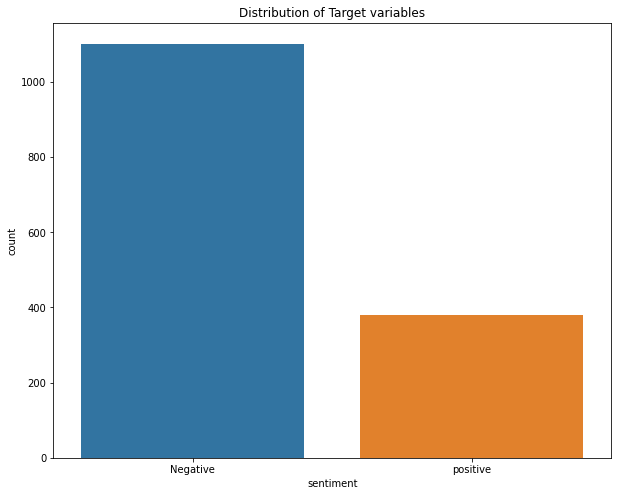

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
ax= sns.countplot(data = data, x='sentiment')
ax.set(title='Distribution of Target variables',xticklabels=['Negative','positive']);

The label data looks imbalanced where neutral takes more than 50 % of the values and postive values very less(11%)

### Check most common words in the dataset using word cloud
visualization where frequnt words appear enlarged as compared to less frequent words

#### common words for the negative sentiments

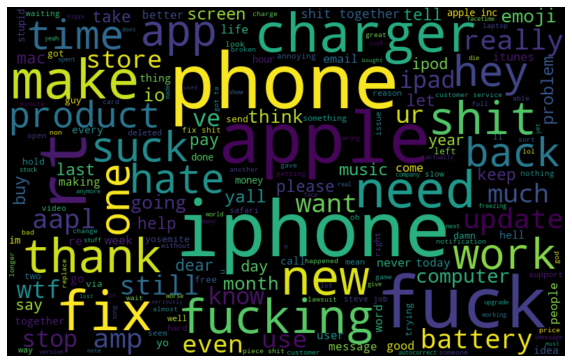

In [18]:
#Negative words
negative_words = ' '.join(data.query("sentiment==1")['cleaned_text'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

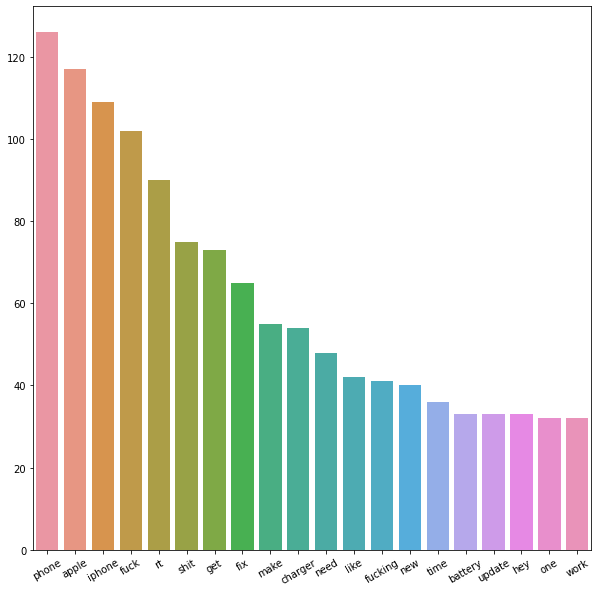

In [19]:
## Creating FreqDist for whole BoW , keeping the 20 most common tokens
negative_tokens = word_tokenize(negative_words) #tokenize data
all_fdist = FreqDist(negative_tokens).most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

#### common words for the positive sentiments

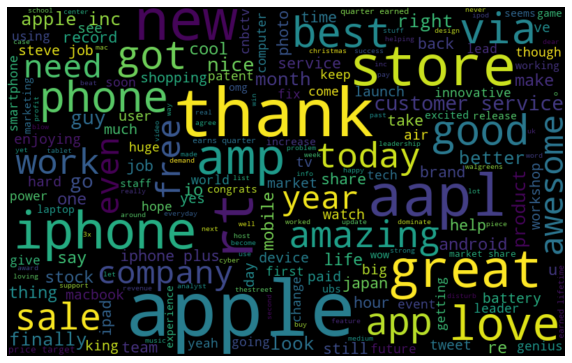

In [20]:
positive_words = ' '.join(data.query('sentiment==5')['cleaned_text'])
wordcloud = WordCloud(width=800, height=500, random_state=21 ,max_font_size=110).generate(positive_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off');

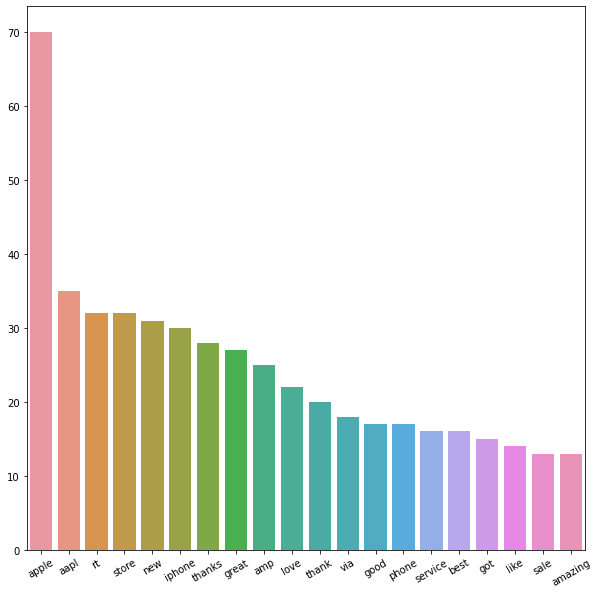

In [21]:
## Creating FreqDist for whole BoW , keeping the 20 most common tokens
positive_tokens = word_tokenize(positive_words)
all_fdist = FreqDist(positive_tokens).most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

In [22]:
#neutral
# neutral_words = ' '.join(data.query("sentiment==3")['cleaned_text'])
# from wordcloud import WordCloud
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neutral_words)

# plt.figure(figsize=(10, 7))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

In [23]:
## Creating FreqDist for whole BoW , keeping the 20 most common tokens
# neutral_tokens = word_tokenize(neutral_words)
# all_fdist = FreqDist(neutral_tokens).most_common(20)

# ## Conversion to Pandas series via Python Dictionary for easier plotting
# all_fdist = pd.Series(dict(all_fdist))

# ## Setting figure, ax into variables
# fig, ax = plt.subplots(figsize=(10,10))

# ## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
# all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
# plt.xticks(rotation=30);

### step 4: Modelling
In this section i will conduct a train_test split for modelling then use pipelines to streamline vectorization, smote and modelling process.
I will then evaluate the models using accuray_score,precision,recall,f1 score and roc auc
The idea behid choosing these models is that we want to rey all the classifiers on the dataset ranging from simple ones to complex models, and then try to find the one which gives the best performance among them and tune it

In [24]:
#split data into x and y
X = data['cleaned_text']
y = data['sentiment']

#split data into a training and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True,random_state=42)

We select our feature variable as X and target variable as y. Then split our data into train and test data for modelling training and evaluation purposes.Shuffke and stratify ensures a well-blanced dataset split,ehich improves model perfomance and evaluation reliability

In [25]:
#create pipeline to streamline vectorization and for modelling, start with base model
#(Logistic Regression)
pipeline = Pipeline([
    ('tdif',TfidfVectorizer(ngram_range=(1,2))),
    ('smote',SMOTE()),
    ('model',LogisticRegression())
])

Pipeline that does text vetorization i.e converting raw text into numerical features using tfidfVectorizer,smote to balance the target class 'sentiment' and using Logistic regression to classify text

In [26]:
def modelling(pipe):
    pipe.fit(X_train, y_train)

    # Predict train and test data
    y_hat_train = pipe.predict(X_train)
    y_hat_test = pipe.predict(X_test)

    # Get accuracy, precision, recall, and F1-score
    base_train_accuracy = accuracy_score(y_train, y_hat_train)
    base_test_accuracy = accuracy_score(y_test, y_hat_test)
    base_train_precision = precision_score(y_train, y_hat_train, average='weighted')
    base_test_precision = precision_score(y_test, y_hat_test, average='weighted')
    base_train_recall = recall_score(y_train, y_hat_train, average='weighted')
    base_test_recall = recall_score(y_test, y_hat_test, average='weighted')
    base_train_f1 = f1_score(y_train, y_hat_train, average='weighted')
    base_test_f1 = f1_score(y_test, y_hat_test, average='weighted')

    # Binarize labels for multiclass ROC curve
    classes = sorted(set(y_train))  # Get unique classes
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    # Get prediction scores
    if hasattr(pipe, "decision_function"):
        y_score_train = pipe.decision_function(X_train)
        y_score_test = pipe.decision_function(X_test)
    else:
        y_score_train = pipe.predict_proba(X_train)
        y_score_test = pipe.predict_proba(X_test)

    # Compute ROC curve and AUC for each class
    train_auc_list, test_auc_list = [], []
    plt.figure(figsize=(8, 6))
    
    # for i in range(len(classes)):
    #     train_fpr, train_tpr, _ = roc_curve(y_train_bin[:, i], y_score_train[:, i])
    #     test_fpr, test_tpr, _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
        
    #     train_auc = auc(train_fpr, train_tpr)
    #     test_auc = auc(test_fpr, test_tpr)
        
    #     train_auc_list.append(train_auc)
    #     test_auc_list.append(test_auc)
        
    #     sns.lineplot(x=test_fpr, y=test_tpr, label=f'Class {classes[i]} - Test AUC: {test_auc:.4f}')
    
    # # Average AUC
    # avg_train_auc = sum(train_auc_list) / len(train_auc_list)
    # avg_test_auc = sum(test_auc_list) / len(test_auc_list)

    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title("Multiclass ROC Curve")
    # plt.legend()
    # plt.show()

    return {
        'Training Accuracy': base_train_accuracy,
        'Test Accuracy': base_test_accuracy,
#         'Training precision': base_train_precision,
        'Test precision': base_test_precision,
#         'Training recall': base_train_recall,
        'Test recall': base_test_recall,
#         'Training f1_score': base_train_f1,
        'Test f1_score': base_test_f1
        # 'Average Train AUC': avg_train_auc,
        # 'Average Test AUC': avg_test_auc
    }


To avoid repetition for varios models that we will be creating, we've defined a function that fits,predicts and calculates the accuracy_score

In [27]:
#logistic Regression evaluation
logreg = modelling(pipeline)
logreg

{'Training Accuracy': 0.9890202702702703,
 'Test Accuracy': 0.8047138047138047,
 'Test precision': 0.800058059088896,
 'Test recall': 0.8047138047138047,
 'Test f1_score': 0.8020087947313975}

<Figure size 576x432 with 0 Axes>

In [28]:
#randomForest
pipeline.set_params(model=RandomForestClassifier(random_state=42))
rdf = modelling(pipeline)
rdf

{'Training Accuracy': 0.9991554054054054,
 'Test Accuracy': 0.7811447811447811,
 'Test precision': 0.7615947838170061,
 'Test recall': 0.7811447811447811,
 'Test f1_score': 0.76028139683723}

<Figure size 576x432 with 0 Axes>

In [29]:
#multinomial naive bayes
pipeline.set_params(model = MultinomialNB())
nb =  modelling(pipeline)
nb

{'Training Accuracy': 0.9881756756756757,
 'Test Accuracy': 0.8013468013468014,
 'Test precision': 0.8212754608794213,
 'Test recall': 0.8013468013468014,
 'Test f1_score': 0.8079216117041176}

<Figure size 576x432 with 0 Axes>

In [30]:
#Decision tree
pipeline.set_params(model = DecisionTreeClassifier(random_state=42))
dt = modelling(pipeline)
dt

{'Training Accuracy': 0.9991554054054054,
 'Test Accuracy': 0.7474747474747475,
 'Test precision': 0.7601366704814981,
 'Test recall': 0.7474747474747475,
 'Test f1_score': 0.7527730581835033}

<Figure size 576x432 with 0 Axes>

In [31]:
#svc
pipeline.set_params(model = svm.SVC())
svm = modelling(pipeline)
svm

{'Training Accuracy': 0.9991554054054054,
 'Test Accuracy': 0.7946127946127947,
 'Test precision': 0.7956228956228957,
 'Test recall': 0.7946127946127947,
 'Test f1_score': 0.7533810852349603}

<Figure size 576x432 with 0 Axes>

In [32]:
pipeline.set_params(model = XGBClassifier())
xgb = modelling(pipeline)
xgb

{'Training Accuracy': 0.9408783783783784,
 'Test Accuracy': 0.7912457912457912,
 'Test precision': 0.7794598587847533,
 'Test recall': 0.7912457912457912,
 'Test f1_score': 0.7826124936322727}

<Figure size 576x432 with 0 Axes>

In [33]:
# Dictionary of model results
model_results = {
    "Logistic Regression": logreg,
    "Random Forest": rdf,
    "Naïve Bayes":nb,
    "Decision Tree": dt,
    "SVM": svm,
    "XGBoost": xgb,
}

# Convert dictionary to DataFrame
df_results = pd.DataFrame.from_dict(model_results, orient='index')

# Display the DataFrame
df_results


,Training Accuracy,Test Accuracy,Test precision,Test recall,Test f1_score
Logistic Regression,0.989020,0.804714,0.800058,0.804714,0.802009
Random Forest,0.999155,0.781145,0.761595,0.781145,0.760281
Naïve Bayes,0.988176,0.801347,0.821275,0.801347,0.807922
Decision Tree,0.999155,0.747475,0.760137,0.747475,0.752773
SVM,0.999155,0.794613,0.795623,0.794613,0.753381
XGBoost,0.940878,0.791246,0.779460,0.791246,0.782612


In [34]:
#checking gaps between train and test accuracy
df_results['Training Accuracy'] - df_results['Test Accuracy']

Logistic Regression    0.184306
Random Forest          0.218011
Naïve Bayes            0.186829
Decision Tree          0.251681
SVM                    0.204543
XGBoost                0.149633
dtype: float64

From the models tested we see varying degrees of overfitting and generalization ability across different models.Decision trees and random Forest performance might fail in real word due to overfitting

Higher AUC is seen in the models indicating models performs well in separating the classes
XGBoost has the bet generalization as it has the smallest gap between the train and test accuracy(10.44%)

I will choose XGBoost as my model and proceed to tune it

### Step:5 Hyperparameter tuning
We'll tune the following parameters:

- **n_estimators**: Number of boosting rounds
- **max_depth**: maximum tree depth (higher=more complex model)
- **learning_rate**: Step size to prevent overfitting
- **subsmaple**: Fraction of samples used per tree(lower=more regularizationO
- **colsample_bytree**: fraction of features used per tree
- **gamma**: minimum loss reduction reqquired for further splitting

In [35]:
#Define paramter grid
param_grid = {
    'model__n_estimators': [100, 300, 500],  
    'model__max_depth': [3, 5, 7],  
    'model__learning_rate': [0.01, 0.1, 0.2],  
    'model__subsample': [0.7, 0.8, 1.0],  
    'model__colsample_bytree': [0.7, 0.8, 1.0],  
    'model__gamma': [0, 0.1, 0.2]  
}

In [36]:
#check pipeline
pipeline

Pipeline(steps=[('tdif', TfidfVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [37]:
# grid_search = GridSearchCV(
#                             estimator = pipeline,
#                             param_grid = param_grid,
#                             scoring = 'accuracy',
#                             verbose=2, 
#                             n_jobs=-1
# )
# grid_search.fit(X_train, y_train)

# #Get Best parameters
# grid_search.best_params_


### Retraining the model with the best parameters

In [38]:
pipeline.set_params(model=XGBClassifier(model__colsample_bytree= 0.7,
 model__gamma= 0.2,
 model__learning_rate= 0.2,
 model__max_depth= 3,
 model__n_estimators= 500,
 model__subsample= 1.0,
 scale_pos_weight=3))


Pipeline(steps=[('tdif', TfidfVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()),
                ('model',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               model__colsample_bytree=0.7, model__gamma=0.2,
                               model__learning_rate=0.2, model__max_depth=3,
                               model__n_estimators=500, model__subsample=1.0,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=3,
                               subsample=None, tree_method=None, ...))])

In [39]:
xgb_tuned = modelling(pipeline)
xgb_tuned

[13:00:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { model__colsample_bytree, model__gamma, model__learning_rate, model__max_depth, model__n_estimators, model__subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




{'Training Accuracy': 0.9484797297297297,
 'Test Accuracy': 0.7811447811447811,
 'Test precision': 0.7820980366434911,
 'Test recall': 0.7811447811447811,
 'Test f1_score': 0.7816118591095248}

<Figure size 576x432 with 0 Axes>

In [40]:
df_results

,Training Accuracy,Test Accuracy,Test precision,Test recall,Test f1_score
Logistic Regression,0.989020,0.804714,0.800058,0.804714,0.802009
Random Forest,0.999155,0.781145,0.761595,0.781145,0.760281
Naïve Bayes,0.988176,0.801347,0.821275,0.801347,0.807922
Decision Tree,0.999155,0.747475,0.760137,0.747475,0.752773
SVM,0.999155,0.794613,0.795623,0.794613,0.753381
XGBoost,0.940878,0.791246,0.779460,0.791246,0.782612


No major improvement in accuracy – The test accuracy and F1 score are nearly the same as before tuning.
AUC improved slightly – The Test AUC increased from 0.8026 to 0.8058, indicating better probability estimates.
Tuning reduced slight overfitting – The training accuracy dropped a bit, meaning the model is generalizing slightly better.

In [41]:
from sklearn.ensemble import StackingClassifier
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1)
log_reg = LogisticRegression(class_weight='balanced', solver='liblinear')

# Stacking Classifier
stacked_model = StackingClassifier(
    estimators=[('xgb', xgb)],
    final_estimator=log_reg,  # Meta model
    passthrough=True
)
pipeline.set_params(model=stacked_model)

Pipeline(steps=[('tdif', TfidfVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()),
                ('model',
                 StackingClassifier(estimators=[('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               gamma=None,
                                                               gpu_id=None,
                                                               importance_type='gain',
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_delta_step=None,
                                                               ma...
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None,
                                                               reg_alpha=None,
                                                               reg_lambda=None,
                                                               scale_pos_weight=None,
                                                               subsample=None,
                                                               tree_method=None,
                                                               validate_parameters=None,
                                                               verbosity=None))],
                                    final_estimator=LogisticRegression(class_weight='balanced',
                                                                       solver='liblinear'),
                                    passthrough=True))])

In [42]:
combined_models = modelling(pipeline)
combined_models

{'Training Accuracy': 0.9459459459459459,
 'Test Accuracy': 0.7777777777777778,
 'Test precision': 0.7621352828821708,
 'Test recall': 0.7777777777777778,
 'Test f1_score': 0.7657527657527657}

<Figure size 576x432 with 0 Axes>

In [43]:
df_results

,Training Accuracy,Test Accuracy,Test precision,Test recall,Test f1_score
Logistic Regression,0.989020,0.804714,0.800058,0.804714,0.802009
Random Forest,0.999155,0.781145,0.761595,0.781145,0.760281
Naïve Bayes,0.988176,0.801347,0.821275,0.801347,0.807922
Decision Tree,0.999155,0.747475,0.760137,0.747475,0.752773
SVM,0.999155,0.794613,0.795623,0.794613,0.753381
XGBoost,0.940878,0.791246,0.779460,0.791246,0.782612


Also combined xgboosting with logist regression for improved perfomance but we see less improvement meaning tha our default models perfome better and we will use it to make predictions

### Step6: Make predictions

In [44]:
#create function to predict sentiment
pipeline.set_params(model = XGBClassifier())
pipeline.fit(X_train,y_train)
def sentiment_check(tweet):
    tweet_processed = clean_text(tweet)
    print(f'tweet:{tweet_processed}')
    prediction = pipeline.predict([tweet_processed])
    return "Negative Statement" if prediction[0] == 1 else "Neutral Statemnet" if prediction[0]==3 else "Positive statement" if prediction[0]==5 else "not_relevant"

print(sentiment_check('this phones suck,its not what is marketed'))

tweet:phone suck marketed
Negative Statement


In [45]:
print(sentiment_check("I bought a new phone and it's so good"))

tweet:bought new phone good
Positive statement


In [46]:
print(sentiment_check("great item, good job"))

tweet:great item good job
Positive statement


#### Our model performs relatively well though itending to move twards neutral it is better than random guess
we can look into using deep learning and other vectorization techniques to see if we can improve our models perfomance

### Step 7: Conclusions and recommendations